 ## Modeling Fraud Detection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

sns.set()

### Relevant Functions

In [2]:
def plot_confusion_matrix(y_test, y_pred):
    cm = metrics.confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(score)
    plt.title(all_sample_title, size = 15);

In [4]:
def plot_auc_curve(fpr, tpr):
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [5]:
def feature_importance(model):
    importances = model.feature_importances_
    indices = np.argsort(importances)
    features = X_train.columns
    plt.figure(figsize = (8,6))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

In [6]:
def model_coeff(model, X):
    print("Model coefficients:\n")
    for i in range(X.shape[1]):
        print(X.columns[i], "=", model.coef_[0,i].round(4))

In [7]:
def plot_impfeatures(models, model_label, ncol=None):
    if ncol is None:
        ncol = 2
    nrow = int(np.ceil(len(models) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 8*nrow), squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, model in enumerate(models):
        ax = axes.flatten()[i]
        print(model)
        importances = model.feature_importances_
        indices = np.argsort(importances)
        features = X_train.columns
        
        ax.barh(range(len(indices)), importances[indices], color='b', align='center')
        ax.set(title=model_label[i])
        ax.set(xlabel='Relative Importance')
        ax.set_yticks(range(len(indices)), [features[i] for i in indices])
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [8]:
def plot_shap_summary(models, model_label, ncol=None):
    if ncol is None:
        ncol = 2
    nrow = int(np.ceil(len(models) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 8*nrow), squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, model in enumerate(models):
        ax = axes.flatten()[i]
        explainer = shap.Explainer(model.predict,X_test)
        lr_shap_values = explainer(X_test)
        #summary_plot
        shap.plots.beeswarm(lr_shap_values)
        plt.title(model_label[i])
        #ax.set(title=model_label[i])
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [9]:
def auc_score(model, y_test, X_test):
    y_pred = model.predict(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    auc_score = metrics.auc(fpr, tpr)
    return auc_score

In [10]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [11]:
final_df = pd.read_csv('../clean_data/final_df.csv')
final_df.head()

,step,amount,isFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,189,58661.89,0,0,1,0,0,0
1,178,115115.39,0,0,1,0,0,0
2,259,6161.67,0,0,0,0,1,0
3,380,72719.13,0,0,1,0,0,0
4,308,17080.99,0,0,0,0,1,0


In [12]:
y = final_df['isFraud']
X = final_df.drop(columns = 'isFraud')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [14]:
from sklearn.linear_model import LogisticRegression

In [15]:
lr = LogisticRegression()

In [16]:
lr.fit(X_train, y_train)

LogisticRegression()

In [17]:
y_pred = lr.predict(X_test)

In [18]:
score = lr.score(X_test, y_test)
print(score)

0.6220254565578307


In [19]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[1318 1414]
 [ 635 2054]]


In [20]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
metrics.auc(fpr, tpr)

0.6231415936190335

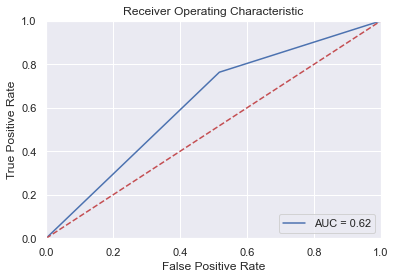

In [21]:
plot_auc_curve(fpr, tpr)

In [22]:
explainer = shap.Explainer(lr.predict,X_test)
lr_shap_values = explainer(X_test)



Exact explainer: 5422it [00:17, 151.09it/s]                                     


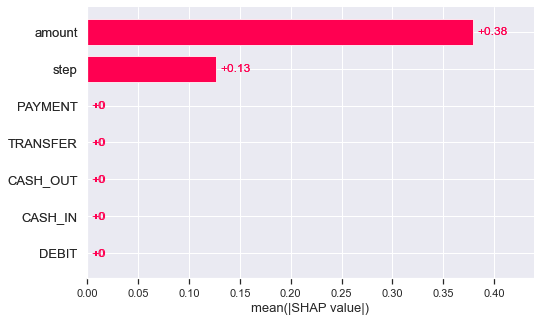

In [23]:
#summary_plot
# fig, ax = plt.subplots(1,2)
shap.plots.bar(lr_shap_values, show = False)
shap.plots.bar(lr_shap_values, show = False)